In [ ]:
#pip install ray torch torchvision
#pip install ray[tune]

In [48]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torch.utils.data
import torchvision.transforms as transforms

In [49]:
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.utils import validate_save_restore

In [50]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), ((0.3081)))])

In [51]:
trainset = torchvision.datasets.MNIST('mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST('mnist', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=0) 

In [52]:
class Net(nn.Module):
    def __init__(self,num_unit):    
        super(Net, self).__init__()
        self.num_unit = num_unit
        self.fc1 = nn.Linear(28 * 28 * 1, self.num_unit)
        self.fc2 = nn.Linear(self.num_unit,10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [57]:
class PytorchTrainble(tune.Trainable):
    def _setup(self, config):
        self.device = torch.device("cuda")
        self.train_loader = trainloader
        self.test_loader = testloader
        self.num_unit = config.get("num_unit",200)
        self.model = Net(self.num_unit).to(self.device)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))

    def _train(self):
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        acc = test(self.model, self.test_loader, self.device)
        return {"mean_accuracy": acc}

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))
        
    def reset_config(self, new_config):
        del self.optimizer
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=new_config.get("lr", 0.01),
            momentum=new_config.get("momentum", 0.9))
        del self.num_unit
        self.num_unit = new_config.get("num_unit",200)
        return True


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)

validate_save_restore(PytorchTrainble)
validate_save_restore(PytorchTrainble, use_object_store=True)
print("Success!")

2020-11-19 16:14:21,887	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-19 16:14:29,137	WARNING worker.py:1091 -- Warning: The actor PytorchTrainble has size 55445867 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-11-19 16:14:33,430	WARNING worker.py:1091 -- Warning: The actor PytorchTrainble has size 55445867 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Success!


In [62]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="mean_accuracy",
    mode="max",
    perturbation_interval=5,
    hyperparam_mutations={
        # distribution for resampling
        "lr": lambda: np.random.uniform(0.0001,0.1),
        # allow perturbations within this set of categorical values
        "momentum": [0.8, 0.9, 0.99],
        "num_unit": [100,400],
    }
)

In [63]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


analysis = tune.run(
    PytorchTrainble,
    name="pbt_test",
    scheduler=scheduler,
    reuse_actors=True,
    verbose=1,
    stop={
        "training_iteration": 100,
    },
    num_samples=8,
    
    # PBT starts by training many neural networks in parallel with random hyperparameters. 
    config={
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.001, 1),
        "num_unit": tune.randint(100,400),
    })

Trial name,status,loc,lr,momentum,num_unit,acc,iter,total time (s)
PytorchTrainble_ef0bc_00000,TERMINATED,,0.00849265,0.9,100,0.902778,100,16.1697
PytorchTrainble_ef0bc_00001,TERMINATED,,0.00884651,0.946727,352,0.982639,100,16.3634
PytorchTrainble_ef0bc_00002,TERMINATED,,0.068165,0.9,400,0.8125,100,15.9656
PytorchTrainble_ef0bc_00003,TERMINATED,,0.00707721,0.8,400,0.979167,100,16.2246
PytorchTrainble_ef0bc_00004,TERMINATED,,0.00567943,0.919605,158,0.975694,100,16.0145
PytorchTrainble_ef0bc_00005,TERMINATED,,0.0568041,0.494536,196,0.961806,100,15.9995
PytorchTrainble_ef0bc_00006,TERMINATED,,0.0409442,0.684965,228,0.982639,100,16.3631
PytorchTrainble_ef0bc_00007,TERMINATED,,0.00707721,0.9,400,0.972222,100,16.1774


2020-11-19 16:20:39,741	INFO tune.py:439 -- Total run time: 61.19 seconds (58.74 seconds for the tuning loop).
2020-11-19 16:20:40,489	ERROR worker.py:1037 -- Possible unhandled error from worker: ray::PytorchTrainble.restore_from_object() (pid=9376, ip=192.168.1.41)
  File "python\ray\_raylet.pyx", line 482, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  File "C:\Users\bluev\Anaconda3\lib\site-packages\ray\function_manager.py", line 553, in actor_method_executor
    return method(actor, *args, **kwargs)
  File "C:\Users\bluev\Anaconda3\lib\site-packages\ray\tune\trainable.py", line 498, in restore_from_object
    self.restore(checkpoint_path)
  File "C:\Users\bluev\Anaconda3\lib\site-packages\ray\tune\trainable.py", line 476, in restore
    self.load_checkpoint(checkpoint_path)
  File "C:\Users\bluev\Anaconda3\lib\site-packages\ray\tune\trainable.py", line 853, in load_checkpoint
    self._restore(checkpoint)
  Fi

I am trying to understand the warning message... it seemed to have size mismatching issues but didn't stop running, or generating compelling errors...
The results are good, and couples of combinations achieved accuracy above 98%. It is definitely a lot easier than doing by hand. Next step I might try to add more layers, and different numbers of neurons in each layer.

<Figure size 1440x360 with 0 Axes>

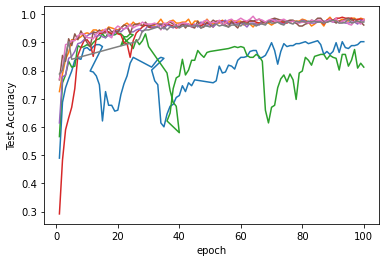

In [64]:
import matplotlib.pyplot as plt
#Plot by wall-clock time
plt.figure(figsize=(20,5))

dfs = analysis.fetch_trial_dataframes()
# This plots everything on the same plot
ax = None
for d in dfs.values():
    ax = d.plot("training_iteration", "mean_accuracy", ax=ax, legend=False)

plt.xlabel("epoch"); plt.ylabel("Test Accuracy");